In [271]:
import pickle

from tqdm import tqdm

from math import pi
from math import cos
from math import sin

from time import time
from time import sleep

from datetime import datetime

from collections import defaultdict

from dataclasses import dataclass

from statistics import mean

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from compas.geometry import Translation

from compas.utilities import pairwise

from compas_cem.diagrams import TopologyDiagram

from compas_cem.elements import Node
from compas_cem.elements import DeviationEdge

from compas_cem.equilibrium import static_equilibrium

from compas_cem.optimization import Optimizer

from compas_cem.optimization import TrailEdgeForceConstraint
from compas_cem.optimization import DeviationEdgeParameter

from compas_cem.plotters import Plotter

In [2]:
def tensegrity_wheel(num_sides, tension_force, compression_force, diameter=1.0, appendix_length=0.1):
    """
    Create the topology diagram of a tensegrity wheel
    """
    # test number of subdivisions is even
    assert num_sides % 2 == 0

    # create a topology diagram
    topology = TopologyDiagram()

    # create nodes, removing last
    thetas = np.linspace(0.0, 2*pi, num_sides + 1)[:-1]
    radius = diameter / 2.0

    for i, theta in enumerate(thetas):

        x = radius * cos(theta)
        y = radius * sin(theta)

        # nodes in the wheel
        topology.add_node(Node(i, [x, y, 0.0]))

    # deviation edges in the perimeter of the wheel tension
    for u, v in pairwise(list(range(num_sides)) + [0]):
        topology.add_edge(DeviationEdge(u, v, force=tension_force))

    # internal deviation edges are in compression
    half_num_sides = num_sides / 2.0

    for u in range(int(half_num_sides)):
        v = int(u + half_num_sides)
        topology.add_edge(DeviationEdge(u, v, force=compression_force))

    # generate trails and auto generate auxiliary trails
    topology.auxiliary_trail_length = appendix_length * -1.0
    topology.build_trails(auxiliary_trails=True)

    return topology


def plot_diagrams(topology, form, form_opt, figsize=(16.0, 9.0), nodesize=0.45, shift=1.4):

    plotter = Plotter(figsize=figsize)

    # plot topology diagram
    plotter.add(topology, nodesize=nodesize)

    # plot translated form diagram
    T = Translation.from_vector([shift, 0.0, 0.0])
    plotter.add(form.transformed(T), nodesize=nodesize)

    # plot translated optimized form diagram
    T = Translation.from_vector([shift * 2.0, 0.0, 0.0])
    plotter.add(form_opt.transformed(T), nodesize=nodesize)

    # show scene
    plotter.zoom_extents(padding=-0.3)
    plotter.show()
    

class Logger:
    opt_attrs = ["time", "evals", "penalty", "grad_norm"]
    
    def __init__(self):
        self.data = defaultdict(list)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 
        
    def log_numsides(self, num_sides):
        self.data["num_sides"].append(num_sides)
        
    def log_topology(self, topology):
        self.data["num_nodes"].append(topology.number_of_nodes())
        self.data["num_edges"].append(topology.number_of_edges())
        
    def log_optimizer(self, optimizer):
        self.data["num_parameters"].append(optimizer.number_of_parameters())
        self.data["num_constraints"].append(optimizer.number_of_constraints())
     
    def log_result(self, result):
        key1 = result.gradient_mode
        key2 = result.step_size_exp
        
        for attr in self.opt_attrs:
            slot = self.opt_data[attr][key1]
            value = getattr(result, attr)
            
            if not key2 in slot:
                slot[key2] = []

            slot[key2].append(value)
    
    def flush_results(self):
        self.data["results"].append(self.opt_data)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 
        
@dataclass
class OptimizationResult:
    evals : float
    time: float
    penalty: float
    grad_norm: float
    gradient_mode: str
    step_size_exp: float
    

In [3]:
num_sides_exponent = [2, 3, 4, 5, 6, 7, 8]

# topology diagram parameters
tension_force = 1.0
compression_force = -1.0
force_bound = 2.0

# optimization parameters
# gradient strategy = {grad method: step_size_exponents}
gradient_strategy = {"AD": [None], "FD": [-3, -6, -9, -12]}
opt_algorithm = "LBFGS"
iters = 1000
eps = 1e-6

# number of experiments to average results on
num_experiments = 10

# visualization
plot = True

 40%|████      | 4/10 [00:00<00:00, 34.30it/s]

***Solving for tensegrity wheel with 4 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Computing gradients using automatic differentiation!
Optimization ended correctly!
Optimization total runtime: 0.0251 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 30%|███       | 3/10 [00:00<00:00, 25.57it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Optimization ended correctly!
Optimization total runtime: 0.0279 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0033
Optimization status: NLOPT_EPSVAL_REACHED
----------


 30%|███       | 3/10 [00:00<00:00, 25.50it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Optimization ended correctly!
Optimization total runtime: 0.0283 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0003
Optimization status: NLOPT_EPSVAL_REACHED
----------


 30%|███       | 3/10 [00:00<00:00, 23.52it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Optimization ended correctly!
Optimization total runtime: 0.0374 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 30%|███       | 3/10 [00:00<00:00, 25.71it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Optimization ended correctly!
Optimization total runtime: 0.0278 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 30%|███       | 3/10 [00:00<00:00, 25.93it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 6, # Constraints 4
Optimization ended correctly!
Optimization total runtime: 0.027 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0001
Optimization status: NLOPT_EPSVAL_REACHED
----------


 20%|██        | 2/10 [00:00<00:00, 19.69it/s]


***Solving for tensegrity wheel with 8 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Computing gradients using automatic differentiation!
Optimization ended correctly!
Optimization total runtime: 0.0371 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 10%|█         | 1/10 [00:00<00:01,  7.78it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Optimization ended correctly!
Optimization total runtime: 0.0937 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0066
Optimization status: NLOPT_EPSVAL_REACHED
----------


 10%|█         | 1/10 [00:00<00:01,  7.94it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Optimization ended correctly!
Optimization total runtime: 0.0923 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0007
Optimization status: NLOPT_EPSVAL_REACHED
----------


 10%|█         | 1/10 [00:00<00:01,  7.98it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Optimization ended correctly!
Optimization total runtime: 0.0913 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 10%|█         | 1/10 [00:00<00:01,  8.11it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Optimization ended correctly!
Optimization total runtime: 0.0905 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


 10%|█         | 1/10 [00:00<00:01,  7.75it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 12, # Constraints 8
Optimization ended correctly!
Optimization total runtime: 0.0946 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0001
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for tensegrity wheel with 16 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16
Computing gradients using automatic differentiation!
Optimization ended correctly!
Optimization total runtime: 0.0708 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16


 10%|█         | 1/10 [00:00<00:03,  2.39it/s]

Optimization ended correctly!
Optimization total runtime: 0.3131 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0111
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16


 10%|█         | 1/10 [00:00<00:03,  2.42it/s]

Optimization ended correctly!
Optimization total runtime: 0.3136 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0011
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16


 10%|█         | 1/10 [00:00<00:03,  2.40it/s]

Optimization ended correctly!
Optimization total runtime: 0.3103 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16


 10%|█         | 1/10 [00:00<00:03,  2.38it/s]

Optimization ended correctly!
Optimization total runtime: 0.3164 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 24, # Constraints 16


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Optimization ended correctly!
Optimization total runtime: 0.3996 seconds
Number of evaluations incurred: 4
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0019
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for tensegrity wheel with 32 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Computing gradients using automatic differentiation!
Optimization ended correctly!

 10%|█         | 1/10 [00:00<00:02,  3.86it/s]


Optimization total runtime: 0.2038 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Optimization ended correctly!


 10%|█         | 1/10 [00:02<00:19,  2.13s/it]

Optimization total runtime: 1.7715 seconds
Number of evaluations incurred: 5
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0146
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Optimization ended correctly!


 10%|█         | 1/10 [00:01<00:12,  1.44s/it]

Optimization total runtime: 1.0711 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0017
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Optimization ended correctly!


 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

Optimization total runtime: 1.1175 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Optimization ended correctly!


 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

Optimization total runtime: 1.1056 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 48, # Constraints 32
Optimization ended correctly!


 10%|█         | 1/10 [00:02<00:19,  2.16s/it]

Optimization total runtime: 1.7809 seconds
Number of evaluations incurred: 5
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0005
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for tensegrity wheel with 64 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Optimization ended correctly!
Optimization total runtime: 0.3414 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Optimization ended correctly!


 10%|█         | 1/10 [00:08<01:14,  8.33s/it]

Optimization total runtime: 6.931 seconds
Number of evaluations incurred: 5
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0207
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Optimization ended correctly!


 10%|█         | 1/10 [00:05<00:49,  5.45s/it]

Optimization total runtime: 3.9969 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0024
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Optimization ended correctly!


 10%|█         | 1/10 [00:05<00:48,  5.38s/it]

Optimization total runtime: 4.0296 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Optimization ended correctly!


 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

Optimization total runtime: 4.1441 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 96, # Constraints 64
Optimization ended correctly!


 10%|█         | 1/10 [00:11<01:39, 11.05s/it]

Optimization total runtime: 9.6142 seconds
Number of evaluations incurred: 7
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.001
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for tensegrity wheel with 128 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Computing gradients using automatic differentiation!
Optimization ended correctly!
Optimization total runtime: 0.7052 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Optimization ended correctly!


 10%|█         | 1/10 [00:32<04:53, 32.64s/it]

Optimization total runtime: 27.0183 seconds
Number of evaluations incurred: 5
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0293
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Optimization ended correctly!


 10%|█         | 1/10 [00:21<03:10, 21.13s/it]

Optimization total runtime: 15.8347 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0033
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Optimization ended correctly!


 10%|█         | 1/10 [00:21<03:11, 21.24s/it]

Optimization total runtime: 15.8868 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Optimization ended correctly!


 10%|█         | 1/10 [00:21<03:10, 21.13s/it]

Optimization total runtime: 15.8265 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0001
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 192, # Constraints 128
Optimization ended correctly!


 10%|█         | 1/10 [01:13<11:03, 73.68s/it]

Optimization total runtime: 68.3983 seconds
Number of evaluations incurred: 13
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0012
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for tensegrity wheel with 256 sides***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Computing gradients using automatic differentiation!
Optimization ended correctly!


 10%|█         | 1/10 [00:01<00:16,  1.82s/it]

Optimization total runtime: 1.2691 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Optimization ended correctly!


 10%|█         | 1/10 [03:05<27:50, 185.58s/it]

Optimization total runtime: 165.3026 seconds
Number of evaluations incurred: 8
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.04
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.0001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Optimization ended correctly!


 10%|█         | 1/10 [01:27<13:11, 87.92s/it]

Optimization total runtime: 65.4984 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0047
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Optimization ended correctly!


 10%|█         | 1/10 [01:26<12:54, 86.08s/it]

Optimization total runtime: 65.0734 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Optimization ended correctly!


 10%|█         | 1/10 [01:27<13:07, 87.54s/it]

Optimization total runtime: 65.8829 seconds
Number of evaluations incurred: 3
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0004
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 384, # Constraints 256
Optimization ended correctly!


 10%|█         | 1/10 [16:39<2:29:58, 999.79s/it]

Optimization total runtime: 977.2757 seconds
Number of evaluations incurred: 44
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0008
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [3:33:42<00:00, 1282.21s/it] 


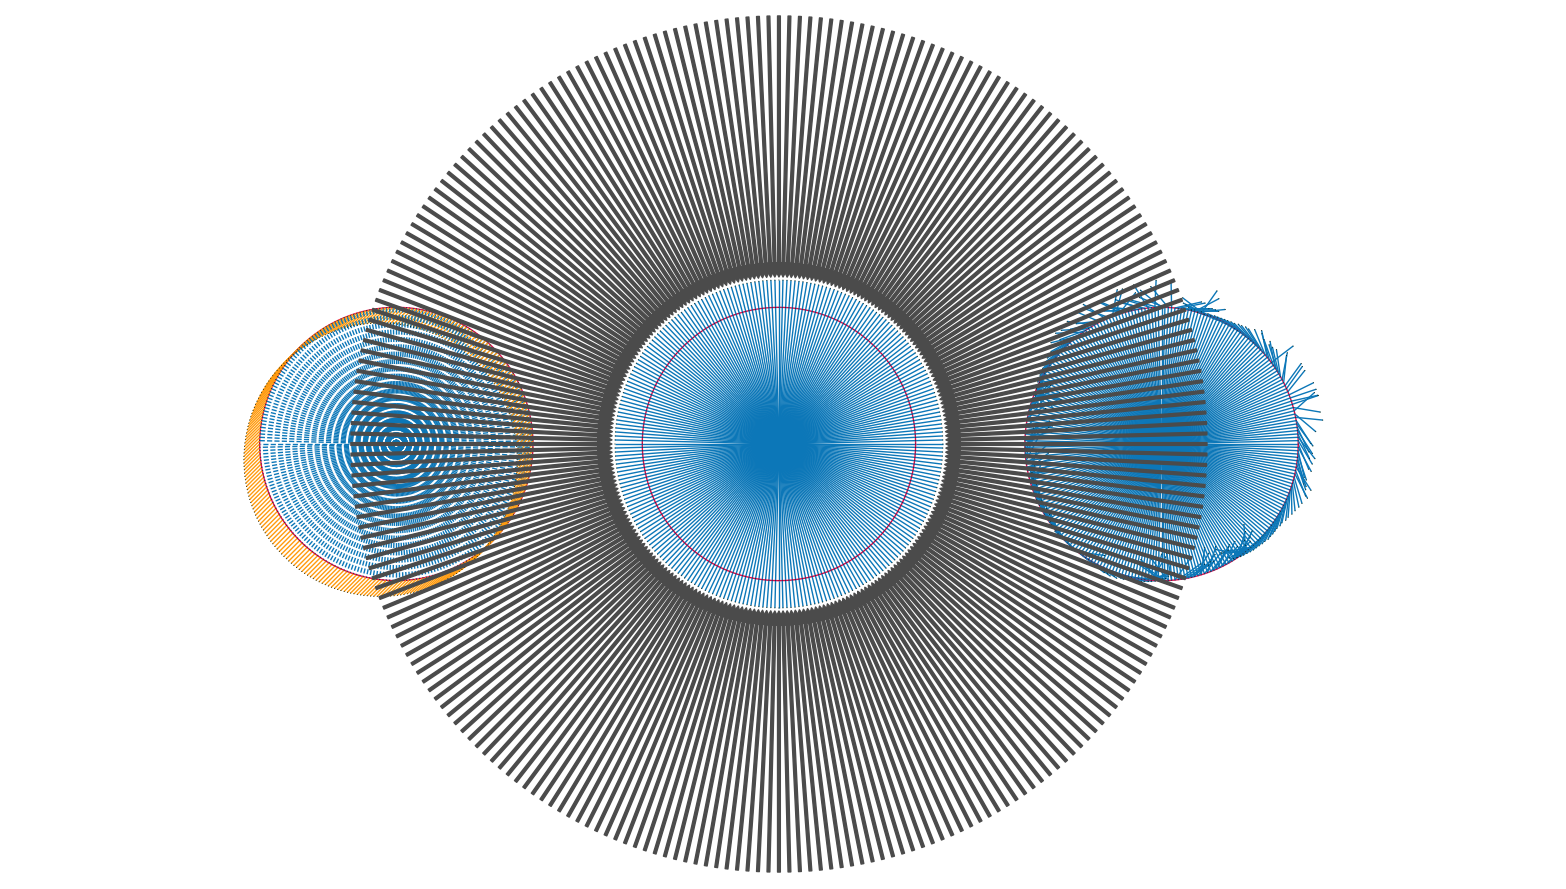

Done!


In [5]:
logger = Logger()

for nse in num_sides_exponent:
    
    # Set wheel's number of sides
    num_sides = 2 ** nse
    print(f"***Solving for tensegrity wheel with {num_sides} sides***\n")
    
    # Create topology diagram
    topology = tensegrity_wheel(num_sides=num_sides,
                                tension_force=tension_force,
                                compression_force=compression_force)
    
    # Form-finding, only for visualization purposes
    form = static_equilibrium(topology)

    # Constrained form-finding
    # Instantiate an optimizer
    opt = Optimizer()

    # Add constraint: force in axiliary trail edges should be zero
    for edge in topology.auxiliary_trail_edges():
        opt.add_constraint(TrailEdgeForceConstraint(edge, force=0.0))

    # Add optimization parameters
    # The forces in all the deviation edges are the degrees of freedom
    # in the optimization problem
    for edge in topology.deviation_edges():
        opt.add_parameter(DeviationEdgeParameter(edge,
                                                 bound_low=force_bound,
                                                 bound_up=force_bound))
    # Log data
    logger.log_numsides(num_sides)
    logger.log_topology(topology)
    logger.log_optimizer(opt)
    
    # Solve constrained form-finding problem
    for gradient_mode, step_size_exps in gradient_strategy.items():
        
        for step_size_exp in step_size_exps:
            step_size = None
            if step_size_exp is not None:
                step_size = 1 * (10 ** step_size_exp)
                
            print(f"Gradient mode: {gradient_mode}\tStep size:{step_size}")
            print(f"Running {num_experiments} experiments...")
            
            for i in tqdm(range(num_experiments)):

                verbose = (i == 0)
                    
                form_opt = opt.solve(topology.copy(),
                                     algorithm=opt_algorithm,
                                     grad=gradient_mode,
                                     iters=iters,
                                     eps=eps,
                                     step_size=step_size,
                                     verbose=verbose)
                
                result = OptimizationResult(evals=opt.evals,
                                            time=opt.time_opt,
                                            penalty=opt.penalty,
                                            grad_norm=opt.gradient_norm,
                                            gradient_mode=gradient_mode,
                                            step_size_exp=step_size_exp)
                
                logger.log_result(result)            
            print() 
            
    logger.flush_results()
    
if plot:
    plot_diagrams(topology, form, form_opt)
        
print("Done!")

In [6]:
for key, value in logger.data.items():
    if key != "results":
        print(f"{key}: {value}")
        continue
    for v in value:
        print(v)

num_sides: [4, 8, 16, 32, 64, 128, 256]
num_nodes: [8, 16, 32, 64, 128, 256, 512]
num_edges: [10, 20, 40, 80, 160, 320, 640]
num_parameters: [6, 12, 24, 48, 96, 192, 384]
num_constraints: [4, 8, 16, 32, 64, 128, 256]
{'time': defaultdict(<class 'dict'>, {'AD': {None: [0.025072097778320312, 0.01981210708618164, 0.019128799438476562, 0.01932382583618164, 0.018182754516601562, 0.018956899642944336, 0.01812601089477539, 0.01982712745666504, 0.018690824508666992, 0.018255949020385742]}, 'FD': {-3: [0.02791595458984375, 0.027933835983276367, 0.028727054595947266, 0.029265165328979492, 0.03051900863647461, 0.027766704559326172, 0.02784109115600586, 0.02899312973022461, 0.02975010871887207, 0.027456998825073242], -4: [0.02834796905517578, 0.027998924255371094, 0.028003931045532227, 0.029812335968017578, 0.02826714515686035, 0.0283048152923584, 0.028204917907714844, 0.028551816940307617, 0.032076120376586914, 0.031434059143066406], -6: [0.037383079528808594, 0.028562068939208984, 0.028084039688

In [7]:
with open("wheel.pkl", "wb") as file:
    pickle.dump(logger.data, file, pickle.HIGHEST_PROTOCOL)

In [723]:
def pretty_matplotlib():
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', linewidth=1.5, labelsize=20)
    plt.rc('xtick', labelsize=20, direction="in")
    plt.rc('ytick', labelsize=20, direction="in")
    plt.rc('legend', fontsize=20)

    # tick settings
    plt.rc('xtick.major', size=10, pad=4)
    plt.rc('xtick.minor', size=5, pad=4)
    plt.rc('ytick.major', size=10)
    plt.rc('ytick.minor', size=5)

    
def create_figure(figsize, dpi):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    return fig


def plot_xy(x, y, label, lw=2.0, alpha=1.0, marker="o", ms=None, color=None):
    return plt.plot(x, y, label=label, lw=lw, alpha=alpha, marker=marker, ms=ms, color=color)
    
    
def save_figure(filename, extension="pdf", box_inches="tight", pad_inches=0.05, sleeptime=1.0):
    path = f"{filename}.{extension}"
    plt.savefig(path, bbox_inches='tight', pad_inches=pad_inches)
    print(f"Saved image to {path}")
    sleep(sleeptime)
    
    
def show_figure():
    plt.show()

    
def decorate_figure(fig, xlabel, ylabel, xticks, yticks, xscale, yscale, xlabels=None, ylabels=None, ylabelpad=None, legend=True, grid_kwargs={}, tight=True, rect=None):
    plt.xscale(xscale)
    plt.yscale(yscale)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel, labelpad=ylabelpad)
    
    xlabels = xlabels or xticks
    plt.xticks(xticks, labels=xlabels)
    ylabels = ylabels or yticks
    plt.yticks(yticks, labels=ylabels)
    
    plt.minorticks_off()
    
    plt.grid(**grid_kwargs)
    
    if legend:
        plt.legend(fontsize="x-small")
        
    if tight:
        plt.tight_layout(rect=rect)

In [747]:
data = logger.data

save = True
show = True

filename = "wheel_opt"
figsize = (7, 5)  # 8, 5
dpi = 300
margins = (0.13, 0.1)

aggregator_func = mean
skippable_step_size_exps = [-4]

x = data["num_parameters"]
xscale = "log"
xlabel = r"\# Optimization parameters"
xticks = [int(_x) for _x in x]

grid = {"ls": "--", "lw": 0.5, "which": "major", "axis": "both"}
markers = {"AD": {None: "o"}, "FD": {-3: "s", -6: "X", -9: "D", -12: "v"}}
colors = {"AD": {None: "tab:blue"}, "FD": {-3: "tab:orange", -6: "tab:green", -9: "tab:red", -12: "tab:purple"}}
alpha = 0.6
lineweights = {"AD": {None: 2.5}, "FD": {-9: 1.}}
lw_default = 2.
markersizes = {"FD": {-6: 8, -9: 4}}
ms_default = 7 


# log y axis with -12
text = {"AD": {None: {"plot": True, "indices": [1, 2, 3, 4, 5, 6], "va": "top", "ha": "left", "tag": "percentage"}},
        "FD": {-3: {"plot": True, "indices": [5, 6], "va": "bottom", "ha": "right", "tag": "percentage"},
               -9: {"plot": True, "indices": [2, 3, 4, 5, 6], "va": "top", "ha": "left", "tag": "percentage"},
              -12: {"plot": True, "indices": [1, 2, 3, 4, 5, 6], "va": "bottom", "ha": "right", "tag": "percentage"}}}

text_evals = {"AD": {None: {"plot": True, "indices": [0, 1, 2, 3, 4, 5, 6], "ha": "right", "tag": "int"}},
              "FD": {-3: {"plot": True, "indices": [4, 5, 6], "va": "bottom", "ha": "right", "tag": "int"},
                     -12: {"plot": True, "indices": [2, 3, 4, 5, 6], "va": "bottom", "ha": "right", "tag": "int"}}}

y_metrics = {"time": {"ylabel": "Time (seconds)",
                      "yticks": None, # [0.1, 1, 10, 100, 1000],
                      "yscale": "log",
                      "text": text},
             "evals": {"ylabel": r"\# Iterations \\ \break",
                       "yticks": [5,10,20,40],
                       "yscale": "log",
                       "ylabelpad": 28,
                       "text": text_evals}
            }

Saved image to wheel_opt_time.pdf


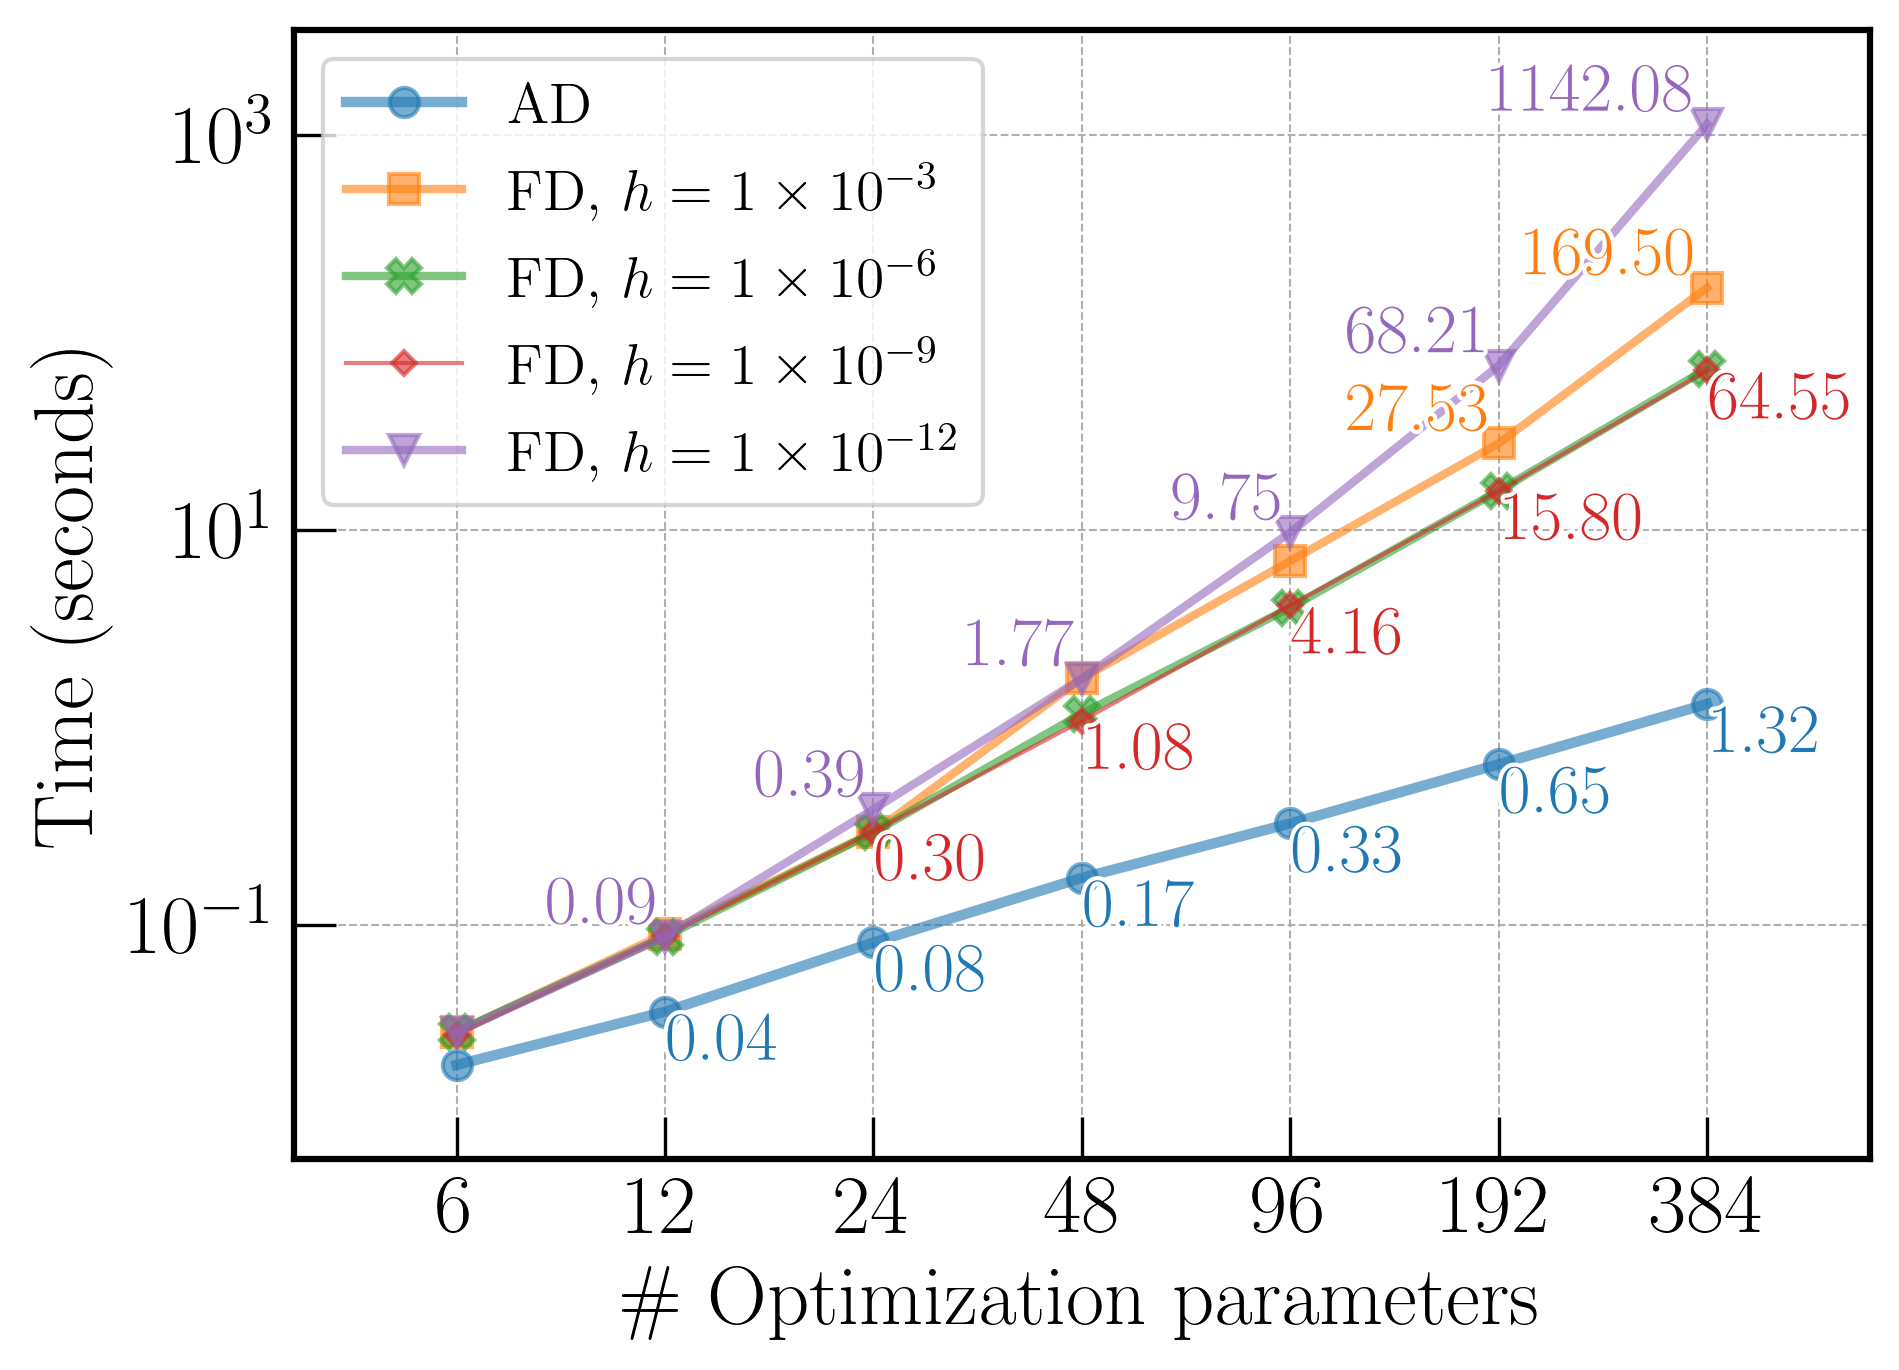

Saved image to wheel_opt_evals.pdf


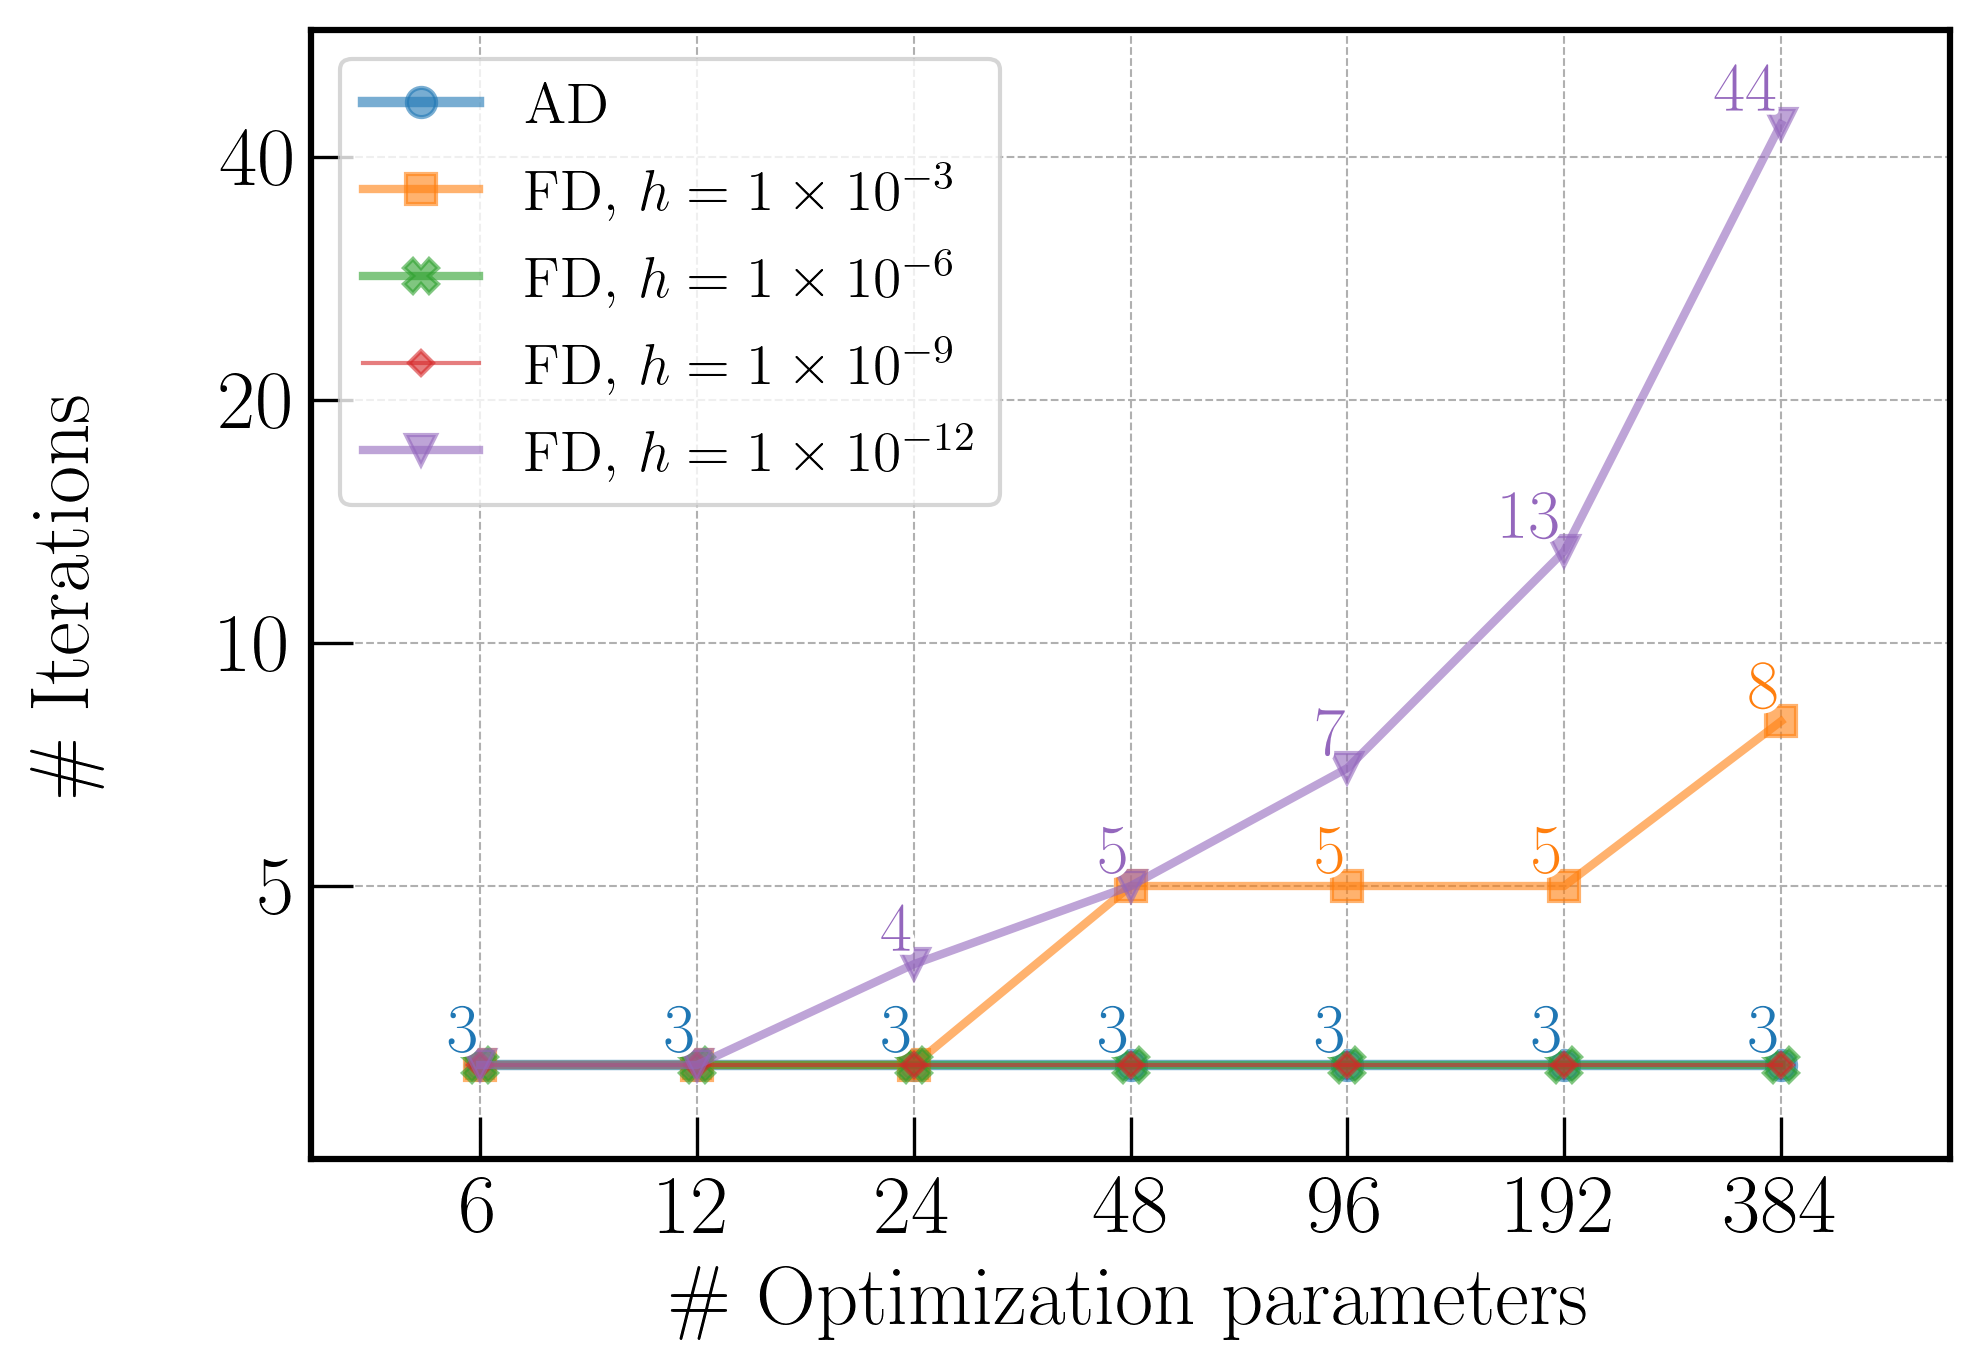

In [751]:
pretty_matplotlib()

for metric, ykwargs in y_metrics.items():
    
    fig = create_figure(figsize, dpi)
    
    for gradient_mode, step_size_exps in gradient_strategy.items():

        for step_size_exp in step_size_exps:

            if step_size_exp in skippable_step_size_exps:
                continue

            label = fr"{gradient_mode}, $h=1\times10^{ {step_size_exp} }$"
            if step_size_exp is None:
                label = r"{}".format(gradient_mode)

            y = []
            for result in data["results"]:
                ys = result[metric][gradient_mode][step_size_exp]
                y.append(aggregator_func(ys))

            color = colors[gradient_mode][step_size_exp]
            
            try:
                lw = lineweights[gradient_mode][step_size_exp]
            except KeyError:
                lw = lw_default
                
            try:
                ms = markersizes[gradient_mode][step_size_exp]
            except KeyError:
                ms = ms_default
            
            lines = plot_xy(x, y, label, color=color, lw=lw, alpha=alpha, ms=ms, marker=markers[gradient_mode][step_size_exp])
            
            # add text
            text = ykwargs["text"]
            try:
                text_kw = text[gradient_mode][step_size_exp]
            except KeyError:
                continue

            if not text_kw["plot"]:
                continue
            
            tag = text_kw["tag"]
            
            for idx in text_kw["indices"]:
                
                if tag == "percentage":
                    text_tag = f"{y[idx]:.2f}"
                elif tag == "int":
                    text_tag = f"{int(y[idx])}"
                    
                plt.text(x[idx],
                         y[idx],
                         text_tag,
                         size=ykwargs.get("text_size", "small"),
                         c=color,
                         ha=text_kw.get("ha", "right"),
                         va=text_kw.get("va", "bottom"),
                         path_effects=[pe.withStroke(linewidth=2, foreground='w')]
                         )

    
    decorate_figure(fig,
                    xlabel=xlabel,
                    ylabel=ykwargs["ylabel"],
                    xticks=xticks,
                    yticks=ykwargs["yticks"],
                    xscale=xscale,
                    yscale=ykwargs["yscale"],
                    ylabels=ykwargs.get("ylabels"),
                    ylabelpad=ykwargs.get("ylabelpad"),
                    grid_kwargs=grid,
                    )
    
    if margins:
        plt.margins(*margins)
    
    if save:
        save_figure(f"{filename}_{metric}")

    if show:
        show_figure()